In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import re
from sentence_transformers import SentenceTransformer

/home/joshua/.local/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Define Tensorflow Model

In [68]:
(2 * np.ones(4)) ** (np.array([8, 9, 10, 11]))

array([ 256.,  512., 1024., 2048.])

In [73]:
np.round(np.log2(384 * 4))

11.0

In [102]:
# Define function to create the neural network model
def create_nn_model(embedding_dim: int, num_of_dense: int) -> Model:
    """
    Creates a neural network model that processes user prompts using an embedding layer,
    concatenates it with function ratings, and passes through dense layers.

    Args:
        embedding_dim (int): Dimensionality of the embedding layer.
        max_length (int): Maximum length of input sequences.
        num_of_dense (int): Number of dense layers before concatenation.

    Returns:
        Model: A compiled TensorFlow model.
    """
    # Text input (user prompt)
    text_input = Input(shape = (embedding_dim,), name = "text_input")

    # Dense layers for text input
    # Start with a power of 2 neurons such that there are at least 4 times
    # the embedding dimension in dense neurons for the first layer
    num_neurons = 2 ** np.round(np.log2(embedding_dim * 4))
#     num_neurons = 2 ** 12
    x = text_input
    # Quarter each subsequent dense layer size
    for _ in range(num_of_dense):
        num_neurons = max(1, int(num_neurons / 4))  # Ensure integer neurons, minimum of 1
#         num_neurons = max(1, int(num_neurons / 2))  # Ensure integer neurons, minimum of 1
        x = Dense(num_neurons, activation = 'relu')(x)

    # Numeric input (func_rating)
    func_rating_input = Input(shape = (6,), name = "func_rating_input")
    y = Dense(32, activation = 'relu')(func_rating_input)

    # Concatenate both paths
    concatenated = Concatenate()([x, y])
    output = Dense(6, activation = 'softmax', name = "output")(concatenated)

    # Define and compile the model
    model = Model(inputs = [text_input, func_rating_input], outputs = output)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

## Load Data and Preprocess

In [93]:
# Read in data from csv
df = pd.read_csv('prompts_and_ratings.csv')
# Drop urls as we will not be using them
df = df.drop(['url_to_check'], axis = 1)
    
# Preprocess prompts by replacing special characters with spaces
# Then, remove extra spaces, strip leading and trailing whitespace characters, and convert to lowercase
# This normalizes the prompts to prepare for vector embedding
df['user_prompt'] = [re.sub('\s+', ' ', re.sub('[^\w\s]', ' ', p)).strip().lower() for p in df['user_prompt']]

# Calculate prompt length as the number of tokens in a prompt for potential future use in modeling
df['prompt_length'] = [len(p.split(' ')) for p in df['user_prompt']]
df

,user_prompt,func_rating,custom_rating,prompt_length
0,i have just been on an international flight ca...,2,3,20
1,what are the benefits of a vegetarian diet,2,4,8
2,what are the benefits of a vegetarian diet,2,2,8
3,what are the benefits of a vegetarian diet,2,3,8
4,how to improve mental health during stressful ...,3,3,8
...,...,...,...,...
297,how does altitude training affect endurance in...,3,3,10
298,what are the safest travel destinations for so...,3,2,11
299,how can travelers find sustainable and eco fri...,3,3,10
300,what cultural experiences should not be missed...,2,4,12


In [94]:
# Create sentence embeddings, using all-MiniLM-L6-v2 model to produce 384 dimension vectors
tokenizer = SentenceTransformer('all-MiniLM-L6-v2')
X_text = np.array([embedder.encode(p) for p in df['user_prompt']])

In [95]:
# Check unique values for ratings to determine number of categories
print(
    f'Unique function ratings: {sorted(df.func_rating.unique())}',
    f'Unique human ratings: {sorted(df.custom_rating.unique())}',
    sep = '\n'
)

Unique function ratings: [0, 1, 2, 3, 4, 5]
Unique human ratings: [0, 1, 2, 3, 4, 5]


In [96]:
# Convert ratings to one-hot categorical arrays, use 6 categories based on 
num_categories = max(len(df.func_rating.unique()), len(df.custom_rating.unique()))
X_rating = tf.keras.utils.to_categorical(np.array(df['func_rating']).reshape(-1, 1), num_categories)
y = tf.keras.utils.to_categorical(np.array(df['custom_rating']).reshape(-1, 1), num_categories)

In [97]:
print(f'X_text shape: {X_text.shape}')
print(f'X_ratings shape: {X_rating.shape}')
print(f'y shape: {y.shape}')

X_text shape: (302, 384)
X_ratings shape: (302, 6)
y shape: (302, 6)


## Instantiate Model

In [103]:
# Create the model
embedding_dim = X_text.shape[1]
num_of_dense_layers = 5  # Example: 2 dense layers before concatenation
model = create_nn_model(embedding_dim, num_of_dense_layers)

## Training

In [104]:
model.fit(
    {'text_input': X_text, 'func_rating_input': X_rating},
    y,
    epochs = 10,
    batch_size = 2,
    validation_split = 0.1,
    verbose = 2
)

Epoch 1/10
136/136 - 2s - loss: 1.6369 - accuracy: 0.4613 - val_loss: 1.7084 - val_accuracy: 0.2581 - 2s/epoch - 14ms/step
Epoch 2/10
136/136 - 1s - loss: 1.3371 - accuracy: 0.5535 - val_loss: 1.6953 - val_accuracy: 0.2581 - 705ms/epoch - 5ms/step
Epoch 3/10
136/136 - 1s - loss: 1.2253 - accuracy: 0.5535 - val_loss: 1.6907 - val_accuracy: 0.2581 - 782ms/epoch - 6ms/step
Epoch 4/10
136/136 - 1s - loss: 1.1659 - accuracy: 0.5609 - val_loss: 1.6824 - val_accuracy: 0.2581 - 592ms/epoch - 4ms/step
Epoch 5/10
136/136 - 1s - loss: 1.1167 - accuracy: 0.5830 - val_loss: 1.6698 - val_accuracy: 0.2581 - 603ms/epoch - 4ms/step
Epoch 6/10
136/136 - 1s - loss: 1.0639 - accuracy: 0.6347 - val_loss: 1.6536 - val_accuracy: 0.3226 - 751ms/epoch - 6ms/step
Epoch 7/10
136/136 - 1s - loss: 1.0286 - accuracy: 0.6531 - val_loss: 1.6374 - val_accuracy: 0.3226 - 624ms/epoch - 5ms/step
Epoch 8/10
136/136 - 1s - loss: 1.0006 - accuracy: 0.6531 - val_loss: 1.6202 - val_accuracy: 0.3548 - 617ms/epoch - 5ms/step
Ep

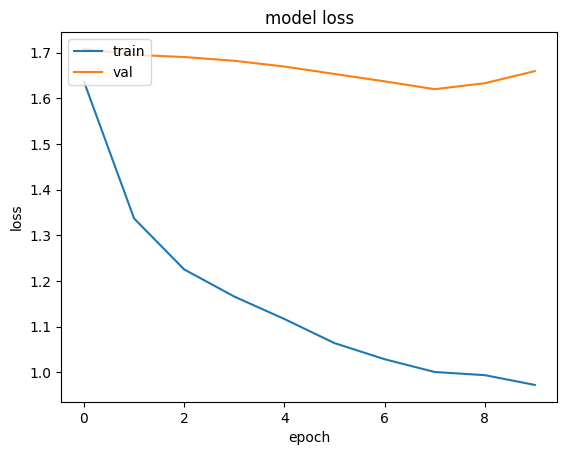

In [105]:
# Plot error
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()